In [2]:
import pandas as pd
import statistics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import warnings
import ast
warnings.filterwarnings('ignore')

In [14]:
PREFIX = '/home/gridsan/arunas/broca/'

og = pd.read_csv(f'{PREFIX}/data-gen/ngs.csv')
gCols = [col for col in og.columns if not 'ng-' in col]
f = pd.read_csv(f'/home/gridsan/arunas/broca/llama/experiments/llama-classification-train-test-det-{gCols[0]}.csv')
m = pd.read_csv(f'/home/gridsan/arunas/broca/mistral/experiments/mistral-classification-train-test-det-{gCols[0]}.csv')
g = pd.read_csv('/home/gridsan/arunas/broca/llama/experiments/llama-classification-train-test-acc.csv')
for col in gCols[1:]:
    f = pd.concat([f, pd.read_csv(f'/home/gridsan/arunas/broca/llama/experiments/llama-classification-train-test-det-{col}.csv')])
    m = pd.concat([m, pd.read_csv(f'/home/gridsan/arunas/broca/mistral/experiments/mistral-classification-train-test-det-{col}.csv')])


['ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender', 'en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-3-qsubordinate', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation', 'jp-u-2-invert', 'jp-u-3-past-tense', 'jap-r-1-sov', 'jap-r-2-passive', 'jap-u-1-negation', 'jap-u-2-invert']


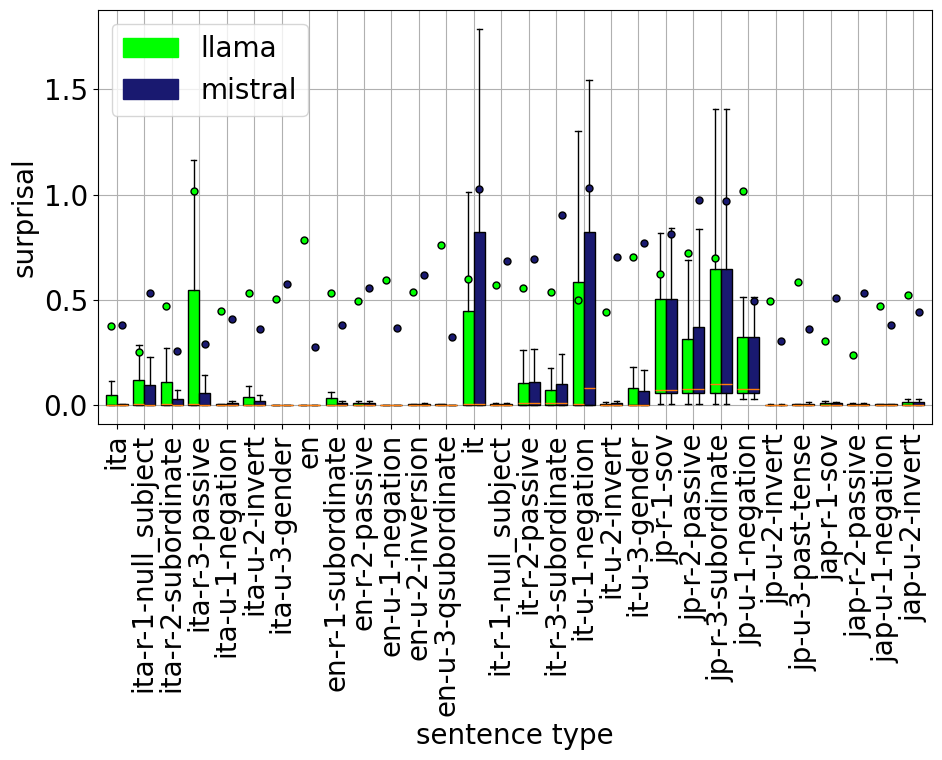

In [51]:
def get_surps(f):
    surps = []
    for idx, row in f.iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)
    all_surps = np.array([i for s in surps for i in s])
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}
    return sorted(all_surps)

ldiff_surps = []
mdiff_surps = []
sfig, ax = plt.subplots(figsize=(10, 8))
print(gCols)
for sent_type_idx, sent_type in enumerate(sorted(f['type'].unique())):
    lg_surps = get_surps(f[(f['type'] == sent_type) & (f['gold'] == 'Yes')])
    lug_surps = get_surps(f[(f['type'] == sent_type) & (f['gold'] == 'No')])
    mg_surps = get_surps(m[(m['type'] == sent_type) & (m['gold'] == 'Yes')])
    mug_surps = get_surps(m[(m['type'] == sent_type) & (m['gold'] == 'No')])

    ldiff_surps.append(lg_surps)
    mdiff_surps.append(lug_surps)
    # ldiff_surps.append([ lug_surps[idx] - lg_surps[idx]  for idx in range(min(len(lg_surps), len(lug_surps)))])
    # mdiff_surps.append([ mug_surps[idx] - mg_surps[idx] for idx in range(min(len(mg_surps), len(mug_surps))) ])

plt.grid()
matplotlib.rc('font', **font)

positions = np.arange(1, len(gCols) + 1)

for i in range(len(gCols)):
    bp = plt.boxplot([ldiff_surps[i], mdiff_surps[i]], positions=[positions[i], positions[i] + 0.4], 
                widths=0.4, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['lime', 'midnightblue']):
        patch.set_facecolor(color)

    for mean, color in zip([bp['means'][0], bp['means'][1]], ['lime', 'midnightblue']):
        mean.set(markerfacecolor=color, marker='o', markersize=5, markeredgecolor="black")

plt.xlabel("sentence type")
plt.xticks(positions + 0.2, gCols, rotation=90)
plt.ylabel("surprisal")
legend_handles = [plt.Rectangle((0,0),0.5,0.5, color='lime'), plt.Rectangle((0,0),0.5,0.5, color='midnightblue')]
plt.legend(legend_handles, ['llama', 'mistral'])

sfig.tight_layout()
sfig.savefig('/home/gridsan/arunas/broca/llama-mistral-ug-g-diff-surprisals.png')
plt.show()

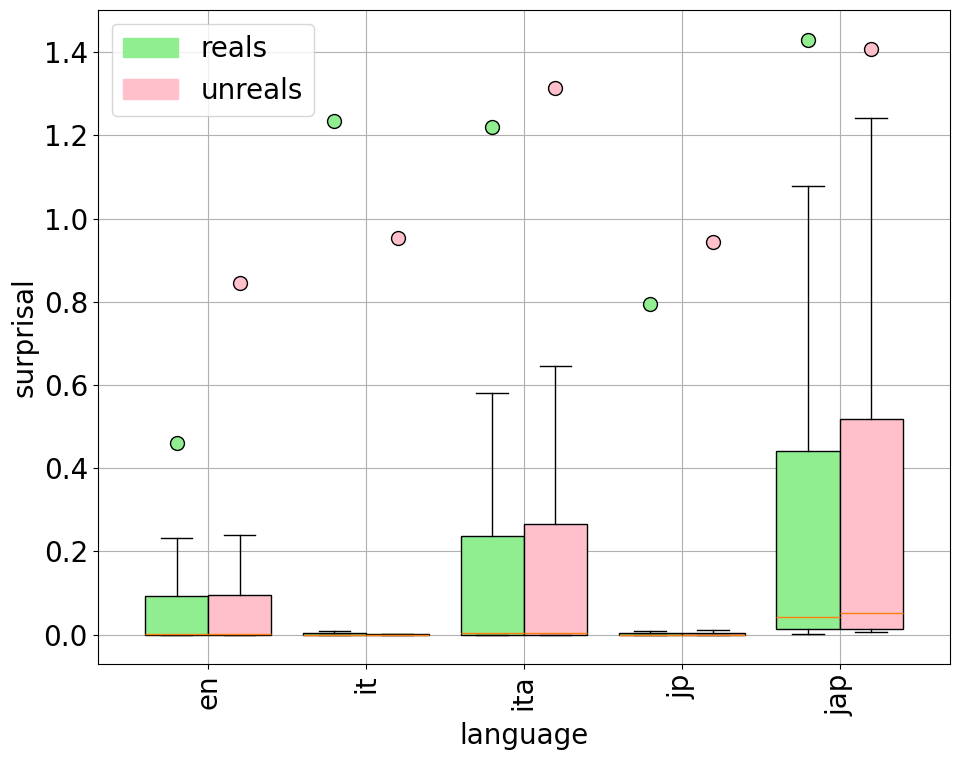

In [48]:
def get_surps(f, cols):
    ur_surps = []
    g_surps = []
    for col in cols:
        if ('-u-' in col):
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                ur_surps.append(myList)
        else:
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                g_surps.append(myList)
                
    allg_surps = np.array([i for s in g_surps for i in s])
    allug_surps = np.array([i for s in ur_surps for i in s])
    return sorted(allg_surps), sorted(allug_surps)

ldiff_surps = []
mdiff_surps = []
sfig, ax = plt.subplots(figsize=(10, 8))

en_real, en_unreal = get_surps(m, ['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-3-qsubordinate'])
it_real, it_unreal = get_surps(m, ['it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender'])
ita_real, ita_unreal = get_surps(m, ['ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender'])
jap_real, jap_unreal = get_surps(m, ['jap-r-1-sov','jap-r-2-passive','jap-u-1-negation','jap-u-2-invert'])
jp_real, jp_unreal = get_surps(m, ['jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation', 'jp-u-2-invert', 'jp-u-3-past-tense'])
reals = [en_real, it_real, ita_real, jp_real, jap_real]
unreals = [en_unreal, it_unreal, ita_unreal, jp_unreal, jap_unreal]
plt.grid()
matplotlib.rc('font', **font)

positions = np.arange(1, len(reals) + 1)

for i in range(len(reals)):
    bp = plt.boxplot([reals[i], unreals[i]], positions=[positions[i], positions[i] + 0.4], 
                widths=0.4, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['lightgreen', 'pink']):
        patch.set_facecolor(color)

    for mean, color in zip([bp['means'][0], bp['means'][1]], ['lightgreen', 'pink']):
        mean.set(markerfacecolor=color, marker='o', markersize=10, markeredgecolor="black")

plt.xlabel("language")
plt.xticks(positions + 0.2, ['en', 'it', 'ita', 'jp', 'jap'], rotation=90)
plt.ylabel("surprisal")
legend_handles = [plt.Rectangle((0,0),1,1, color='lightgreen'), plt.Rectangle((0,0),1,1, color='pink')]
plt.legend(legend_handles, ['reals', 'unreals'], loc='upper left')

sfig.tight_layout()
sfig.savefig('/home/gridsan/arunas/broca/mistral/experiments/mistral-surprisals-r-u.png')
plt.show()

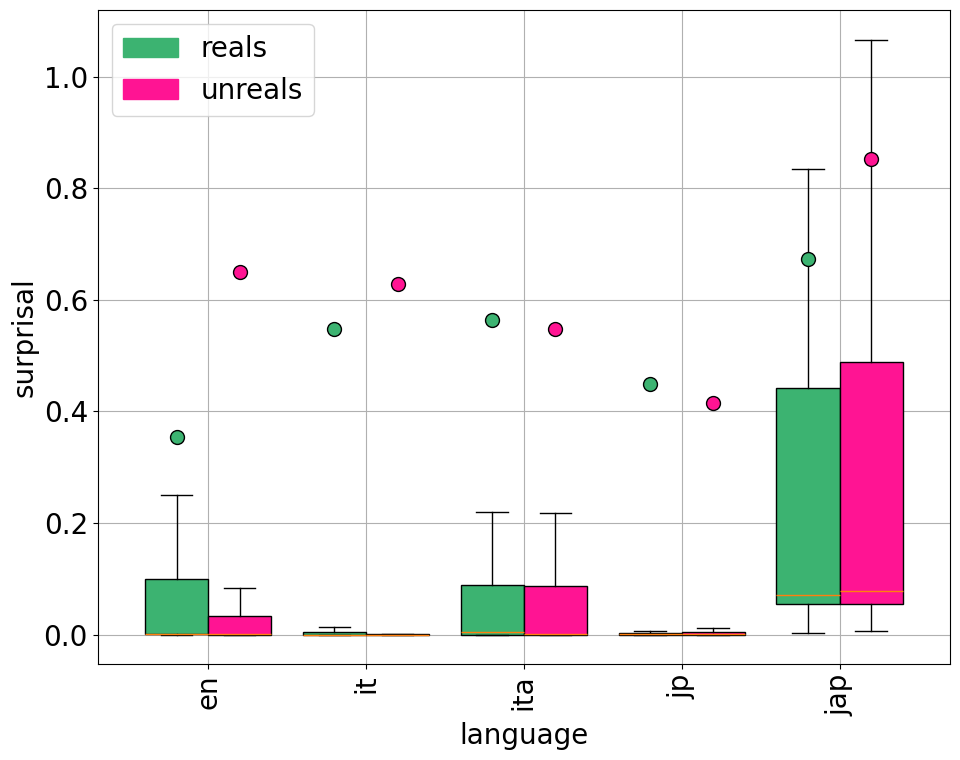

In [49]:
def get_surps(f, cols):
    ur_surps = []
    g_surps = []
    for col in cols:
        if ('-u-' in col):
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                ur_surps.append(myList)
        else:
            for idx, row in f[(f['type'] == col) & (f['gold'] == 'Yes')].iterrows():
                myList = []
                for i in list(ast.literal_eval(row['surprisal'])):
                    myList.append(i[1])
                g_surps.append(myList)
                
    allg_surps = np.array([i for s in g_surps for i in s])
    allug_surps = np.array([i for s in ur_surps for i in s])
    return sorted(allg_surps), sorted(allug_surps)

ldiff_surps = []
mdiff_surps = []
sfig, ax = plt.subplots(figsize=(10, 8))

en_real, en_unreal = get_surps(f, ['en', 'en-r-1-subordinate', 'en-r-2-passive', 'en-u-1-negation', 'en-u-2-inversion', 'en-u-3-qsubordinate'])
it_real, it_unreal = get_surps(f, ['it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender'])
ita_real, ita_unreal = get_surps(f, ['ita', 'ita-r-1-null_subject', 'ita-r-2-subordinate', 'ita-r-3-passive', 'ita-u-1-negation', 'ita-u-2-invert', 'ita-u-3-gender'])
jap_real, jap_unreal = get_surps(f, ['jap-r-1-sov','jap-r-2-passive','jap-u-1-negation','jap-u-2-invert'])
jp_real, jp_unreal = get_surps(f, ['jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation', 'jp-u-2-invert', 'jp-u-3-past-tense'])
reals = [en_real, it_real, ita_real, jp_real, jap_real]
unreals = [en_unreal, it_unreal, ita_unreal, jp_unreal, jap_unreal]
plt.grid()
matplotlib.rc('font', **font)

positions = np.arange(1, len(reals) + 1)

for i in range(len(reals)):
    bp = plt.boxplot([reals[i], unreals[i]], positions=[positions[i], positions[i] + 0.4], 
                widths=0.4, autorange=True, patch_artist=True, showfliers=False, vert=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['mediumseagreen', 'deeppink']):
        patch.set_facecolor(color)

    for mean, color in zip([bp['means'][0], bp['means'][1]], ['mediumseagreen', 'deeppink']):
        mean.set(markerfacecolor=color, marker='o', markersize=10, markeredgecolor="black")

plt.xlabel("language")
plt.xticks(positions + 0.2, ['en', 'it', 'ita', 'jp', 'jap'], rotation=90)
plt.ylabel("surprisal")
legend_handles = [plt.Rectangle((0,0),1,1, color='mediumseagreen'), plt.Rectangle((0,0),1,1, color='deeppink')]
plt.legend(legend_handles, ['reals', 'unreals'], loc='upper left')

sfig.tight_layout()
sfig.savefig('/home/gridsan/arunas/broca/llama/experiments/llama-surprisals-r-u.png')
plt.show()